<a href="https://colab.research.google.com/github/im-p/synteettinen_data/blob/master/gan_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multivariate gan
### numerical + categorical data generation


In [1]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/im-p/synteettinen_data/master/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Prepare data

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

le = LabelEncoder()
df["region_l"] = le.fit_transform(df.region)
"""
df["smoker_l"] = le.fit_transform(df.smoker)
df["sex_l"] = le.fit_transform(df.sex)
"""

'\ndf["smoker_l"] = le.fit_transform(df.smoker)\ndf["sex_l"] = le.fit_transform(df.sex)\n'

In [3]:
df.head()

,age,sex,bmi,children,smoker,region,charges,region_l
0,19,female,27.900,0,yes,southwest,16884.92400,3
1,18,male,33.770,1,no,southeast,1725.55230,2
2,28,male,33.000,3,no,southeast,4449.46200,2
3,33,male,22.705,0,no,northwest,21984.47061,1
4,32,male,28.880,0,no,northwest,3866.85520,1


In [4]:
data = df.drop(["sex", "smoker", "region", "region_l"], 1)
colnames_all = list(data)
mms = MinMaxScaler()
data[colnames_all] = mms.fit_transform(data[colnames_all])
data.sample(5)

,age,bmi,children,charges
1272,0.543478,0.257197,1.0,0.213197
156,0.652174,0.227603,0.0,0.320866
264,0.760870,0.594566,0.6,0.308724
326,0.195652,0.195050,0.2,0.038948
1334,0.000000,0.429379,0.0,0.017305


In [0]:
data["region_l"] = df.region_l

In [6]:
colnames_all = list(data)
colnames_all

['age', 'bmi', 'children', 'charges', 'region_l']

In [7]:
import numpy as np
from numpy import hstack, zeros, ones
from numpy.random import rand, randn, randint
data.iloc[np.random.randint(0, data.shape[0], 10)]

,age,bmi,children,charges,region_l
240,0.108696,0.557170,0.4,0.596818,0
628,0.869565,0.592951,0.0,0.163517,3
164,0.413043,0.368039,0.0,0.062352,1
553,0.739130,0.424267,0.4,0.160671,1
244,0.978261,0.316922,0.0,0.453343,0
800,0.521739,0.274953,0.2,0.094573,2
1323,0.521739,0.656712,0.4,0.682769,2
769,0.434783,0.094566,0.4,0.092761,1
991,0.434783,0.319478,0.4,0.096139,0
1210,0.391304,0.401264,0.2,0.067863,1


Using TensorFlow backend.







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Gan loss:  0.8980419


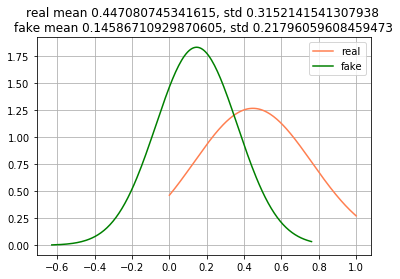

Gan loss:  1.5248085


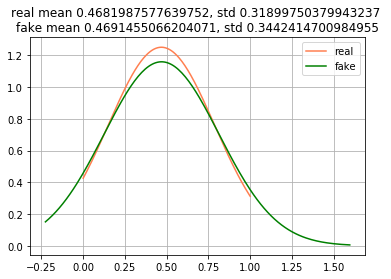

Gan loss:  1.1802373


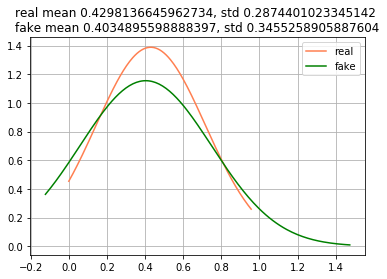

Gan loss:  0.9816838


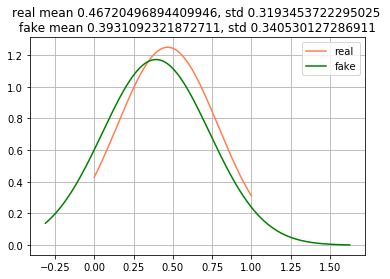

Gan loss:  1.1917855


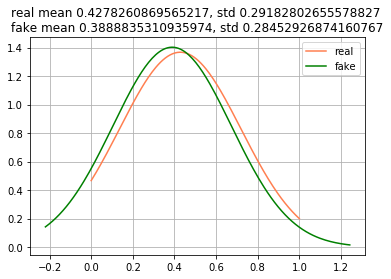

Gan loss:  1.4919064


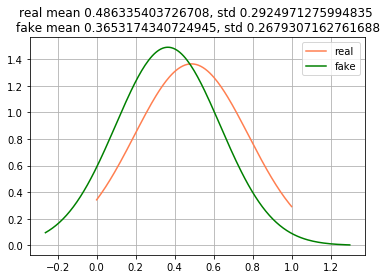

Gan loss:  1.487508


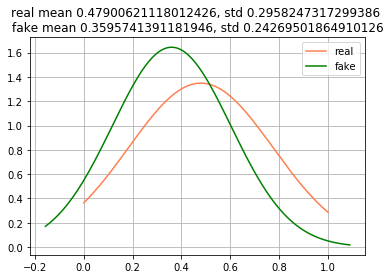

Gan loss:  1.8373666


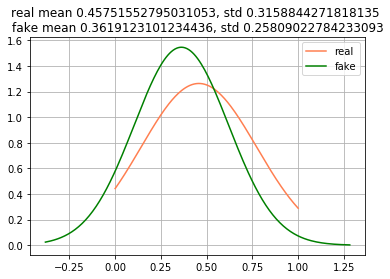

Gan loss:  0.93211114


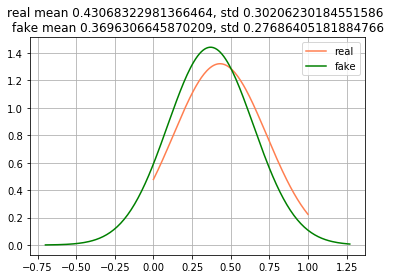

Gan loss:  1.2820528


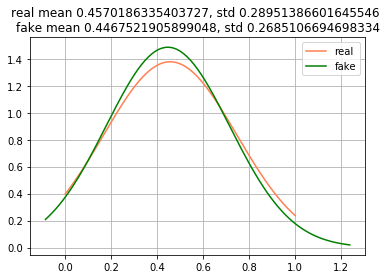

In [8]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
import scipy.stats

def normal_distribution(r, f):
    r_x_min = r.min()
    r_x_max = r.max()
    f_x_min = f.min()
    f_x_max = f.max()

    r_mean = r.mean()
    r_std = r.std()
    f_mean = f.mean()
    f_std = f.std()

    r_x = np.linspace(r_x_min, r_x_max, len(r))
    f_x = np.linspace(f_x_min, f_x_max, len(f))

    r_y = scipy.stats.norm.pdf(r_x, r_mean, r_std)
    f_y = scipy.stats.norm.pdf(f_x, f_mean, f_std)
    
    plt.plot(r_x, r_y, color="coral", label = "real")
    plt.plot(f_x, f_y, color="green", label = "fake")
    title = title = f"real mean {r_mean}, std {r_std} \nfake mean {f_mean}, std {f_std}"
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

# define the standalone discriminator model
def define_discriminator(n_inputs):
	model = Sequential()
	model.add(Dense(64,  kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(LeakyReLU(0.2))
	model.add(Dense(32,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(0.2))
	model.add(Dense(16,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(0.2))
	model.add(Dense(8,  kernel_initializer='he_uniform'))
	model.add(LeakyReLU(alpha=0.01))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs):
	model = Sequential()
	model.add(Dense(15, activation="relu", kernel_initializer="he_uniform", input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.01))
	model.add(Dense(n_outputs, activation="linear"))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss="binary_crossentropy", optimizer="adam")
	return model
 
# generate n real samples with class labels
def generate_real_samples(data, n):
    ix = np.random.randint(0, data.shape[0], n)
    x = data.iloc[ix].values
    y = ones((n,1))
    return x, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, dataset, n_epochs=10000, n_batch=350, n_eval=1000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		x_real, y_real = generate_real_samples(dataset, half_batch)
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)

		x_gan = generate_latent_points(latent_dim, n_batch)

		y_gan = ones((n_batch, 1))

		gan_loss = gan_model.train_on_batch(x_gan, y_gan)

		if (i+1) % n_eval == 0:
			print("Gan loss: ", gan_loss)
			#original_data = mms.inverse_transform(x_real)
			#synthetic_data = mms.inverse_transform(x_fake)
			normal_distribution(x_real[:,0], x_fake[:,0])

    
  

# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator(data.shape[1])
# create the generator
generator = define_generator(latent_dim, data.shape[1])
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim, data)

### Use generator to generate new data

In [0]:
syn, _ = generate_fake_samples(generator, latent_dim, n=1000)
syn2 = mms.inverse_transform(syn[:,[0,1,2,3]])
#df_syn = pd.DataFrame(data = syn, columns = colnames_all)
data = np.append(syn2, syn[:,[4]], axis = 1)
df_syn = pd.DataFrame(data = data, columns = colnames_all)

### Comparing generated data to original

In [19]:
print("Generated mean:\n", df_syn.mean())
print("Generated std:\n", df_syn.std())
print("---------------------")
print("Real mean:\n", df.mean())
print("Real std:\n", df.std())

Generated mean:
 age            36.719879
bmi            29.475685
children        1.240805
charges     15001.712891
region_l        2.035135
dtype: float32
Generated std:
 age            11.040695
bmi             7.881524
children        1.215973
charges     12805.655273
region_l        0.663408
dtype: float32
---------------------
Real mean:
 age            39.207025
bmi            30.663397
children        1.094918
charges     13270.422265
region_l        1.515695
dtype: float64
Real std:
 age            14.049960
bmi             6.098187
children        1.205493
charges     12110.011237
region_l        1.104885
dtype: float64


age normaalijakauma:


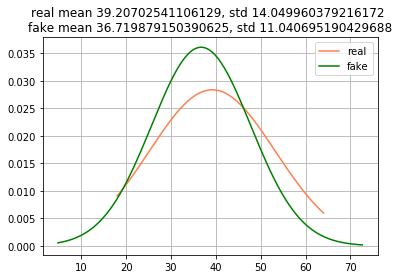

bmi normaalijakauma:


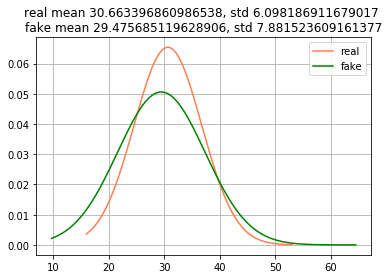

children normaalijakauma:


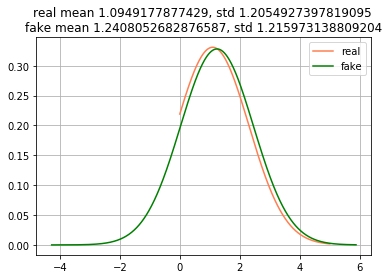

charges normaalijakauma:


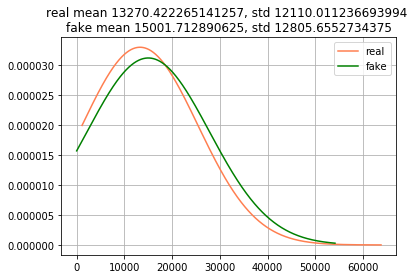

region_l normaalijakauma:


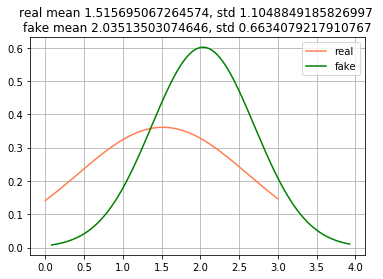

In [17]:
for i in colnames_all:
    print(i, "normaalijakauma:")
    normal_distribution(df[i], df_syn[i])

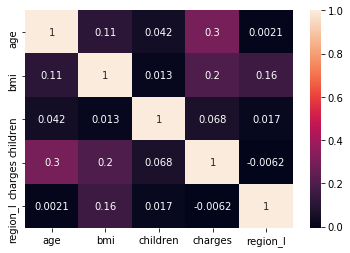

In [20]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True)

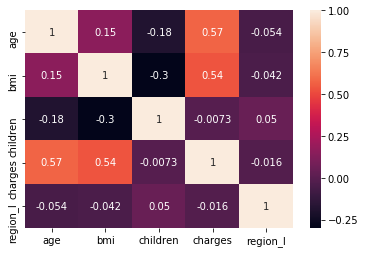

In [21]:
sns.heatmap(df_syn.corr(), annot=True)